In [1]:
from tensorflow.keras.layers import Activation, Input, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.constraints import max_norm
from tensorflow import keras


def EEGInception(input_time=1000, fs=128, ncha=8, filters_per_branch=8,
                 scales_time=(500, 250, 125), dropout_rate=0.25,
                 activation='elu', n_classes=2, learning_rate=0.001):
    
    """Keras implementation of EEG-Inception. All hyperparameters and
    architectural choices are explained in the original article:
    https://doi.org/10.1109/TNSRE.2020.3048106
    Parameters
    ----------
    input_time : int
        EEG epoch time in milliseconds
    fs : int
        Sample rate of the EEG
    ncha :
        Number of input channels
    filters_per_branch : int
        Number of filters in each Inception branch
    scales_time : list
        Temporal scale (ms) of the convolutions on each Inception module.
        This parameter determines the kernel sizes of the filters
    dropout_rate : float
        Dropout rate
    activation : str
        Activation
    n_classes : int
        Number of output classes
    learning_rate : float
        Learning rate
    Returns
    -------
    model : keras.models.Model
        Keras model already compiled and ready to work
    """

    # ============================= CALCULATIONS ============================= #
    input_samples = int(input_time * fs / 1000)
    scales_samples = [int(s * fs / 1000) for s in scales_time]

    # ================================ INPUT ================================= #
    input_layer = Input((input_samples, ncha, 1))

    # ========================== BLOCK 1: INCEPTION ========================== #
    b1_units = list()
    for i in range(len(scales_samples)):
        unit = Conv2D(filters=filters_per_branch,
                      kernel_size=(scales_samples[i], 1),
                      kernel_initializer='he_normal',
                      padding='same')(input_layer)
        unit = BatchNormalization()(unit)
        unit = Activation(activation)(unit)
        unit = Dropout(dropout_rate)(unit)

        unit = DepthwiseConv2D((1, ncha),
                               use_bias=False,
                               depth_multiplier=2,
                               depthwise_constraint=max_norm(1.))(unit)
        unit = BatchNormalization()(unit)
        unit = Activation(activation)(unit)
        unit = Dropout(dropout_rate)(unit)

        b1_units.append(unit)

    # Concatenation
    b1_out = keras.layers.concatenate(b1_units, axis=3)
    b1_out = AveragePooling2D((4, 1))(b1_out)

    # ========================== BLOCK 2: INCEPTION ========================== #
    b2_units = list()
    for i in range(len(scales_samples)):
        unit = Conv2D(filters=filters_per_branch,
                      kernel_size=(int(scales_samples[i]/4), 1),
                      kernel_initializer='he_normal',
                      use_bias=False,
                      padding='same')(b1_out)
        unit = BatchNormalization()(unit)
        unit = Activation(activation)(unit)
        unit = Dropout(dropout_rate)(unit)

        b2_units.append(unit)

    # Concatenate + Average pooling
    b2_out = keras.layers.concatenate(b2_units, axis=3)
    b2_out = AveragePooling2D((2, 1))(b2_out)

    # ============================ BLOCK 3: OUTPUT =========================== #
    b3_u1 = Conv2D(filters=int(filters_per_branch*len(scales_samples)/2),
                   kernel_size=(8, 1),
                   kernel_initializer='he_normal',
                   use_bias=False,
                   padding='same')(b2_out)
    b3_u1 = BatchNormalization()(b3_u1)
    b3_u1 = Activation(activation)(b3_u1)
    b3_u1 = AveragePooling2D((2, 1))(b3_u1)
    b3_u1 = Dropout(dropout_rate)(b3_u1)

    b3_u2 = Conv2D(filters=int(filters_per_branch*len(scales_samples)/4),
                   kernel_size=(4, 1),
                   kernel_initializer='he_normal',
                   use_bias=False,
                   padding='same')(b3_u1)
    b3_u2 = BatchNormalization()(b3_u2)
    b3_u2 = Activation(activation)(b3_u2)
    b3_u2 = AveragePooling2D((2, 1))(b3_u2)
    b3_out = Dropout(dropout_rate)(b3_u2)

    # Output layer
    output_layer = Flatten()(b3_out)
    output_layer = Dense(n_classes, activation='softmax')(output_layer)

    # ================================ MODEL ================================= #
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9,
                                      beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model




In [11]:
# Code to read the files
# The files are stores in the eeg-data folder
import numpy as np
import pandas as pd
from scipy import stats
import os
subject_name = 'subject_020'
src_dir = 'Desktop/eeg-data/Subjects-Data/' + subject_name +'/'
list_dir = os.listdir(src_dir)
print (list_dir)
from BCI2kReader import BCI2kReader as b2k 
subject_to_signals =  {}  #dictionary; key= subject, value = data

for subject_dir in os.listdir(src_dir)[0:85]:
   
    if not subject_dir.startswith("."):
            if (subject_dir.endswith(".dat")):
                with b2k.BCI2kReader(src_dir+subject_dir, "training1.dat") as file: 
                    subject_to_signals[subject_dir] = file.read()



['PF32_2016_11_30_train32FFS001R02.dat', 'PF32_2016_11_30_train32FFS001R03.dat', 'pf_training.prm', 'PF32_2016_11_30_train32FFS001R04.dat']


In [3]:
import numpy as np
import pandas as pd

from scipy import stats
import os
#subject_name = 'subject_048'
src_dir = '../Desktop/eeg-data/Bagging-Data/' 
#out_dir = 'Desktop/eeg-data/output/'+ subject_name +'_results.pdf'
list_dir = os.listdir(src_dir)
print (list_dir)
from BCI2kReader import BCI2kReader as b2k 
subject_to_signals =  {}  #dictionary; key= subject, value = data

for sub_root_dir in os.listdir(src_dir):

    if not sub_root_dir.startswith("."):
        
        for subject_dir in os.listdir(src_dir+sub_root_dir+'/')[0:85]:
   
            if not subject_dir.startswith("."):
                    if (subject_dir.endswith(".dat")):
                        with b2k.BCI2kReader(src_dir+sub_root_dir+'/'+subject_dir, "BaggingTrain.dat") as file: 
                            subject_to_signals[subject_dir] = file.read()


['subject_008', '.DS_Store', 'subject_009', 'subject_007', 'subject_014', 'subject_013', 'subject_012', 'subject_015', 'subject_002', 'subject_005', 'subject_004', 'subject_019', 'subject_017', 'subject_016', 'subject_011', 'subject_018']


In [4]:
# Prepare the data for training
# Train data is for EEGNet trainng & testing as well as RG+xDawn evaluation
#192 temporal data points are used for EEGNet 
#Iterative work pointed that 128 temporal points for ech event produced gives best LDA performance

window = 192   #Signal time series window
sht_window = 128 # shoretened window for LDA analysis
subject_name = []
z_score = []
zerozscore = []
#print (subject_to_signals)
array_elements = sht_window * 32

#Train_data = np.array(np.empty((0,32,window), float))  # Training data array initialization
Train_data = np.array(np.empty((0,window,32), float))  # Training data array initialization

Train_labels = []   # Training label data initialization
Train_data_flattened = np.array(np.empty((0,array_elements), float))  # Training data array initialization



for subject, my_signals in subject_to_signals.items():
   # print (my_signals)
    #Train_data_temp = np.array(np.empty((0,32,window), float))  # Training data array initialization
    Train_data_temp = np.array(np.empty((0,window,32), float))  # Training data array initialization
    
    Train_labels_temp = []   # Training label data initialization
    Train_data_flattened_temp = np.array(np.empty((0,array_elements), float))  # Training data array initialization

    stimuluscode = (my_signals[1]['StimulusCode']) #ndarrays ; target 
    stimulustype = (my_signals[1]['StimulusType']) #p3label
    data = stimuluscode[0] #target numbers
    data_label = stimulustype[0] #p3label numbers
    rownum = len(data)
    labelrow = len(data_label)
    zerozscore = (-1*np.mean(my_signals[0])/(my_signals[0]).std())
    
    change = [] #indexes of 0 where next index is nonzero for target
    for x in range(rownum-1):    
        if bool(data.item(x) == 0) and bool(data.item(x + 1) != 0): 
                change.append(x)
      
    
    
    attended = [] #indexes where p3label value is 1
    nonattended = [] #indexes where p3label value is 0


    nonattended_count =1
   
    for x in range(len(change)): 
      
        attended_values = np.empty((0,window), float) #2D array with train data each row in same a time frame
        nonattended_values = np.empty((0,window), float)
        attended_values_sht = np.empty((0,sht_window), float) #2D array with train data each row in same a time frame
        nonattended_values_sht = np.empty((0,sht_window), float)
 
        if bool(data_label.item(change[x] + 1) == 0): 
            nonattended_count =nonattended_count +1    
            nonattended.append(change[x])
            Train_labels_temp.append(int(0))
            for num in range(len(my_signals[0])):
                electrode = my_signals[0][num]
                zelectrode = stats.zscore(my_signals[0][num])
                nonattendedtemp = []
                nonattendedtemp_sht =[]
                if (change[x] + window) > len(zelectrode):
                    addtime = len(zelectrode) - (change[x])            
                    for y in range(addtime):
                        nonattendedtemp.append(zelectrode[change[x] + y])
                    for y in range(sht_window):
                        nonattendedtemp_sht.append(zelectrode[change[x] + y])
                    nonattended_values_sht = np.append(nonattended_values_sht, np.array([nonattendedtemp_sht]), axis = 0)               
                    nonattended_values = np.append(nonattended_values, np.array([nonattendedtemp]), axis = 0)
                else:
                    for y in range(window):
                        nonattendedtemp.append(zelectrode[change[x] + y])
                    for y in range(sht_window):
                        nonattendedtemp_sht.append(zelectrode[change[x] + y])
                nonattended_values = np.append(nonattended_values, np.array([nonattendedtemp]), axis = 0)
                nonattended_values_sht = np.append(nonattended_values_sht, np.array([nonattendedtemp_sht]), axis = 0)               
            #if nonattended_count % 5 == 0:
            Train_data_flattened_temp = np.append(Train_data_flattened_temp, np.array([nonattended_values_sht.flatten()]), axis=0)
            Train_data_temp = np.append(Train_data_temp,np.array([nonattended_values.T]), axis=0)
        else: 
            attended.append(change[x] + 1) 
            Train_labels_temp.append(int(1))
          
            for num in range(len(my_signals[0])):
                electrode = my_signals[0][num]
                zelectrode = stats.zscore(my_signals[0][num])
                attendedtemp = []
                attendedtemp_sht = []
        
                for y in range(window): 
                    attendedtemp.append(zelectrode[change[x] + y])
                for y in range(sht_window): 
                    attendedtemp_sht.append(zelectrode[change[x] + y])

                attended_values = np.append(attended_values, np.array([attendedtemp]), axis = 0)
                attended_values_sht = np.append(attended_values_sht, np.array([attendedtemp_sht]), axis = 0)

            Train_data_flattened_temp = np.append( Train_data_flattened_temp, np.array([attended_values_sht.flatten()]), axis=0)
            Train_data_temp = np.append( Train_data_temp,np.array([attended_values.T]), axis=0)        
    
    Train_data_flattened = np.concatenate((Train_data_flattened, Train_data_flattened_temp),axis=0) # format is in (trials, channels, samples)
    Train_data = np.concatenate((Train_data, Train_data_temp),axis=0) # format is in (trials, channels, samples)
    Train_labels = np.concatenate((Train_labels, Train_labels_temp),axis=0) 
    
    print("no of labled P300 events:"+str(len(attended)))
    print("no of non_attended P300 events:"+str(len(nonattended)))
    
print(np.shape(Train_data))
print(np.shape(Train_labels))
print(np.shape(Train_data_flattened))

no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:

In [5]:

#%% IMPORT LIBRARIES
import numpy as np
import h5py, os
#from EEGInception import EEGInception
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV

#%% PARAMETERS

#dataset_path = 'Desktop/GIB-UVA ERP-BCI.hdf5'

#%% HYPERPARAMETERS

input_time = 1000
fs = 192
n_cha = 32
filters_per_branch = 8
scales_time = (500, 250, 125)
dropout_rate = 0.25
activation = 'elu'
n_classes = 2
learning_rate = 0.001

#%% LOAD DATASET
#hf = h5py.File(dataset_path, 'r')
#features = np.array(hf.get("features"))
#erp_labels = np.array(hf.get("erp_labels"))
#codes = np.array(hf.get("codes"))
#trials = np.array(hf.get("trials"))
#sequences = np.array(hf.get("sequences"))
#matrix_indexes = np.array(hf.get("matrix_indexes"))
#run_indexes = np.array(hf.get("run_indexes"))
#subjects = np.array(hf.get("subjects"))
#database_ids = np.array(hf.get("database_ids"))
#target = np.array(hf.get("target"))
#matrix_dims = np.array(hf.get("matrix_dims"))
#hf.close()

#End_index = len(Train_labels)
#Train_index = (int) (End_index * 0.8)

#features=Train_data[0:Train_index,]
#erp_labels = Train_labels[0:Train_index,]
#X_test = Train_data[Train_index:,]
#Y_test = Train_labels[Train_index:]

features, X_test, erp_labels, Y_test = train_test_split(Train_data, Train_labels, test_size=0.20, random_state=42)


#%% PREPARE FEATURES AND LABELS
# Reshape epochs for EEG-Inception
X_test = X_test.reshape(
    (X_test.shape[0], X_test.shape[1],
     X_test.shape[2], 1)
)
features = features.reshape(
    (features.shape[0], features.shape[1],
     features.shape[2], 1)
)

# One hot encoding of labels
def one_hot_labels(caategorical_labels):
    enc = OneHotEncoder(handle_unknown='ignore')
    on_hot_labels = enc.fit_transform(
        caategorical_labels.reshape(-1, 1)).toarray()
    return on_hot_labels


train_erp_labels = one_hot_labels(erp_labels)
Y_test = one_hot_labels(Y_test)    

#%%  TRAINING
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'



In [6]:
# Create model
model = EEGInception(
   input_time=1000, fs=192, ncha=32, filters_per_branch=8,
   scales_time=(500, 250, 125), dropout_rate=0.25,
   activation='elu', n_classes=2, learning_rate=0.001)

# Print model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0.0001,
    mode='min', patience=10, verbose=1,
    restore_best_weights=True)

# Fit model
fit_hist = model.fit(features,
                     train_erp_labels,
                     epochs=500,
                     batch_size=16,
                     validation_split=0.2,
                     callbacks=[early_stopping])

# Save
model.save('model')


2022-10-22 16:52:05.794216: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 192, 32, 8)   776         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 32, 8)   392         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 192, 32, 8)   200         ['input_1[0][0]']            

2022-10-22 21:31:17.364445: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


In [7]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("EEG Inception Classification accuracy: %f " % (acc))


names        = ['Non-Attended', 'Attended']


from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results
display_results(Y_test.argmax(axis = -1), preds, names)
#display_results(Y_test.argmax(axis=-1), preds, names)


EEG Inception Classification accuracy: 0.945476 
Overall Categorical Accuracy: 94.55%


,Precision,Recall,F-Score,Support
Non-Attended,0.961154,0.974041,0.967555,7011.0
Attended,0.859459,0.801296,0.829359,1389.0


<Figure size 432x288 with 0 Axes>

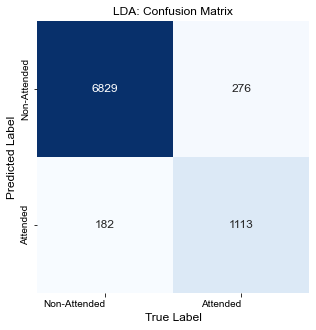

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.0)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title + ": Confusion Matrix", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
    ax.set_ylabel('Predicted Label', fontsize=12)
    ax.set_xlabel('True Label', fontsize=12)

plt.figure(0)
fig, (ax3) = plt.subplots(1, 1, figsize=(6, 5))
plot_heatmap(preds,Y_test.argmax(axis=-1), names, ax3, title = 'LDA')


In [12]:

import numpy as np
import pandas as pd
import csv
from scipy import stats
import os
print (list_dir)
from BCI2kReader import BCI2kReader as b2k 
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
#subject_name = 'subject_048'
src_dir = '../Desktop/eeg-data/CV-test/' 
#out_dir = 'Desktop/eeg-data/output/'+ subject_name +'_results.pdf'
list_dir1 = os.listdir(src_dir)


# tools for plotting confusion matrices
from matplotlib import pyplot as plt

f=open('../Desktop/eeg-data/eeginception-cv.csv', 'w')
csv_writer = csv.writer(f)


def display_results(y_true, y_preds, class_labels,method, subject):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print(method + " Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    print(results)
    data1=[subject,global_acc,results.iat[1,0],results.iat[1,1],results.iat[1,2], results.iat[1,3]]
    csv_writer.writerow(data1)
    return results


def get_data(subject_to_signals) :

# Prepare the data for training
# Train data is for EEGNet trainng & testing as well as RG+xDawn evaluation
#192 temporal data points are used for EEGNet 
#Iterative work pointed that 128 temporal points for ech event produced gives best LDA performance

    window = 192   #Signal time series window
    sht_window = 128 # shoretened window for LDA analysis
    subject_name = []
    z_score = []
    zerozscore = []
    #print (subject_to_signals)
    array_elements = sht_window * 32

    #Train_data = np.array(np.empty((0,32,window), float))  # Training data array initialization
    Train_data = np.array(np.empty((0,window,32), float))  # Training data array initialization

    Train_labels = []   # Training label data initialization
    Train_data_flattened = np.array(np.empty((0,array_elements), float))  # Training data array initialization



    for subject, my_signals in subject_to_signals.items():
       # print (my_signals)
        #Train_data_temp = np.array(np.empty((0,32,window), float))  # Training data array initialization
        Train_data_temp = np.array(np.empty((0,window,32), float))  # Training data array initialization

        Train_labels_temp = []   # Training label data initialization
        Train_data_flattened_temp = np.array(np.empty((0,array_elements), float))  # Training data array initialization

        stimuluscode = (my_signals[1]['StimulusCode']) #ndarrays ; target 
        stimulustype = (my_signals[1]['StimulusType']) #p3label
        data = stimuluscode[0] #target numbers
        data_label = stimulustype[0] #p3label numbers
        rownum = len(data)
        labelrow = len(data_label)
        zerozscore = (-1*np.mean(my_signals[0])/(my_signals[0]).std())

        change = [] #indexes of 0 where next index is nonzero for target
        for x in range(rownum-1):    
            if bool(data.item(x) == 0) and bool(data.item(x + 1) != 0): 
                    change.append(x)



        attended = [] #indexes where p3label value is 1
        nonattended = [] #indexes where p3label value is 0


        nonattended_count =1

        for x in range(len(change)): 

            attended_values = np.empty((0,window), float) #2D array with train data each row in same a time frame
            nonattended_values = np.empty((0,window), float)
            attended_values_sht = np.empty((0,sht_window), float) #2D array with train data each row in same a time frame
            nonattended_values_sht = np.empty((0,sht_window), float)

            if bool(data_label.item(change[x] + 1) == 0): 
                nonattended_count =nonattended_count +1    
                nonattended.append(change[x])
                Train_labels_temp.append(int(0))
                for num in range(len(my_signals[0])):
                    electrode = my_signals[0][num]
                    zelectrode = stats.zscore(my_signals[0][num])
                    nonattendedtemp = []
                    nonattendedtemp_sht =[]
                    if (change[x] + window) > len(zelectrode):
                        addtime = len(zelectrode) - (change[x])            
                        for y in range(addtime):
                            nonattendedtemp.append(zelectrode[change[x] + y])
                        for y in range(sht_window):
                            nonattendedtemp_sht.append(zelectrode[change[x] + y])
                        nonattended_values_sht = np.append(nonattended_values_sht, np.array([nonattendedtemp_sht]), axis = 0)               
                        nonattended_values = np.append(nonattended_values, np.array([nonattendedtemp]), axis = 0)
                    else:
                        for y in range(window):
                            nonattendedtemp.append(zelectrode[change[x] + y])
                        for y in range(sht_window):
                            nonattendedtemp_sht.append(zelectrode[change[x] + y])
                    nonattended_values = np.append(nonattended_values, np.array([nonattendedtemp]), axis = 0)
                    nonattended_values_sht = np.append(nonattended_values_sht, np.array([nonattendedtemp_sht]), axis = 0)               
                #if nonattended_count % 5 == 0:
                Train_data_flattened_temp = np.append(Train_data_flattened_temp, np.array([nonattended_values_sht.flatten()]), axis=0)
                Train_data_temp = np.append(Train_data_temp,np.array([nonattended_values.T]), axis=0)
            else: 
                attended.append(change[x] + 1) 
                Train_labels_temp.append(int(1))

                for num in range(len(my_signals[0])):
                    electrode = my_signals[0][num]
                    zelectrode = stats.zscore(my_signals[0][num])
                    attendedtemp = []
                    attendedtemp_sht = []

                    for y in range(window): 
                        attendedtemp.append(zelectrode[change[x] + y])
                    for y in range(sht_window): 
                        attendedtemp_sht.append(zelectrode[change[x] + y])

                    attended_values = np.append(attended_values, np.array([attendedtemp]), axis = 0)
                    attended_values_sht = np.append(attended_values_sht, np.array([attendedtemp_sht]), axis = 0)

                Train_data_flattened_temp = np.append( Train_data_flattened_temp, np.array([attended_values_sht.flatten()]), axis=0)
                Train_data_temp = np.append( Train_data_temp,np.array([attended_values.T]), axis=0)        

        Train_data_flattened = np.concatenate((Train_data_flattened, Train_data_flattened_temp),axis=0) # format is in (trials, channels, samples)
        Train_data = np.concatenate((Train_data, Train_data_temp),axis=0) # format is in (trials, channels, samples)
        Train_labels = np.concatenate((Train_labels, Train_labels_temp),axis=0) 

        print("no of labled P300 events:"+str(len(attended)))
        print("no of non_attended P300 events:"+str(len(nonattended)))

    print(np.shape(Train_data))
    print(np.shape(Train_labels))
    return Train_data, Train_labels    
    

for sub_root_dir in os.listdir(src_dir):
    print(src_dir+sub_root_dir)
    if not (sub_root_dir.startswith(".") or sub_root_dir in list_dir):
        subject_to_signals =  {}  #dictionary; key= subject, value = data
        for subject_dir in os.listdir(src_dir+sub_root_dir+'/')[0:85]:
   
            if not subject_dir.startswith("."):
                    if (subject_dir.endswith(".dat")):
                        with b2k.BCI2kReader(src_dir+sub_root_dir+'/'+subject_dir, "Inception-Bagging.dat") as file: 
                            subject_to_signals[subject_dir] = file.read()
        X_test, Y_test = get_data(subject_to_signals)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
        Y_test = one_hot_labels(Y_test)    
        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == Y_test.argmax(axis=-1))
        print("EEG Inception Classification accuracy: %f " % (acc))
        display_results(Y_test.argmax(axis = -1), preds, names , "EEGInception",sub_root_dir)

f.close()


['subject_008', '.DS_Store', 'subject_009', 'subject_007', 'subject_014', 'subject_013', 'subject_012', 'subject_015', 'subject_002', 'subject_005', 'subject_004', 'subject_019', 'subject_017', 'subject_016', 'subject_011', 'subject_018']
/users/raviravipati/Desktop/eeg-data/CV-test/subject_039


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.912500 
EEGInception Overall Categorical Accuracy: 91.25%
              Precision    Recall   F-Score  Support
Non-Attended   0.962453  0.931333  0.946637   3000.0
Attended       0.704448  0.818333  0.757132    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_037


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.947500 
EEGInception Overall Categorical Accuracy: 94.75%
              Precision  Recall   F-Score  Support
Non-Attended   0.962488   0.975  0.968703   3000.0
Attended       0.866310   0.810  0.837209    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/.DS_Store
/users/raviravipati/Desktop/eeg-data/CV-test/subject_030


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.845278 
EEGInception Overall Categorical Accuracy: 84.53%
              Precision    Recall   F-Score  Support
Non-Attended   0.865172  0.964667  0.912214   3000.0
Attended       0.584314  0.248333  0.348538    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_064


no of labled P300 events:220
no of non_attended P300 events:1100
no of labled P300 events:220
no of non_attended P300 events:1100
(2640, 192, 32)
(2640,)


EEG Inception Classification accuracy: 0.935227 
EEGInception Overall Categorical Accuracy: 93.52%
              Precision    Recall   F-Score  Support
Non-Attended   0.943207  0.981364  0.961907   2200.0
Attended       0.883191  0.704545  0.783818    440.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_063


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.940000 
EEGInception Overall Categorical Accuracy: 94.00%
              Precision  Recall   F-Score  Support
Non-Attended   0.971066  0.9565  0.963728   2000.0
Attended       0.797674  0.8575  0.826506    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_031


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.913056 
EEGInception Overall Categorical Accuracy: 91.31%
              Precision    Recall   F-Score  Support
Non-Attended   0.923951  0.976000  0.949262   3000.0
Attended       0.832947  0.598333  0.696411    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_036


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.965000 
EEGInception Overall Categorical Accuracy: 96.50%
              Precision  Recall   F-Score  Support
Non-Attended   0.965953   0.993  0.979290   3000.0
Attended       0.959302   0.825  0.887097    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_038


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.975833 
EEGInception Overall Categorical Accuracy: 97.58%
              Precision    Recall   F-Score  Support
Non-Attended   0.978640  0.992667  0.985603   3000.0
Attended       0.960503  0.891667  0.924806    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_053


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.887500 
EEGInception Overall Categorical Accuracy: 88.75%
              Precision  Recall   F-Score  Support
Non-Attended   0.948187   0.915  0.931298   2000.0
Attended       0.638298   0.750  0.689655    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_054


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.843750 
EEGInception Overall Categorical Accuracy: 84.38%
              Precision  Recall   F-Score  Support
Non-Attended   0.889688  0.9275  0.908201   2000.0
Attended       0.539683  0.4250  0.475524    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_062


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.916667 
EEGInception Overall Categorical Accuracy: 91.67%
              Precision  Recall   F-Score  Support
Non-Attended   0.955927  0.9435  0.949673   2000.0
Attended       0.734742  0.7825  0.757869    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_065


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.890417 
EEGInception Overall Categorical Accuracy: 89.04%
              Precision  Recall  F-Score  Support
Non-Attended   0.941985  0.9255  0.93367   2000.0
Attended       0.657471  0.7150  0.68503    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_047


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.926250 
EEGInception Overall Categorical Accuracy: 92.62%
              Precision  Recall   F-Score  Support
Non-Attended   0.955978  0.9555  0.955739   2000.0
Attended       0.778055  0.7800  0.779026    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_078


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.850000 
EEGInception Overall Categorical Accuracy: 85.00%
              Precision    Recall   F-Score  Support
Non-Attended   0.918817  0.899474  0.909043   3800.0
Attended       0.545238  0.602632  0.572500    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_040


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.951111 
EEGInception Overall Categorical Accuracy: 95.11%
              Precision    Recall   F-Score  Support
Non-Attended   0.962647  0.979333  0.970919   3000.0
Attended       0.886861  0.810000  0.846690    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_076


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.870000 
EEGInception Overall Categorical Accuracy: 87.00%
              Precision  Recall   F-Score  Support
Non-Attended   0.929735   0.913  0.921292   2000.0
Attended       0.600917   0.655  0.626794    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_082


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.907018 
EEGInception Overall Categorical Accuracy: 90.70%
              Precision    Recall   F-Score  Support
Non-Attended   0.927342  0.963947  0.945290   3800.0
Attended       0.775410  0.622368  0.690511    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_071


no of labled P300 events:180
no of non_attended P300 events:900
no of labled P300 events:180
no of non_attended P300 events:900
(2160, 192, 32)
(2160,)


EEG Inception Classification accuracy: 0.906481 
EEGInception Overall Categorical Accuracy: 90.65%
              Precision    Recall   F-Score  Support
Non-Attended   0.917887  0.975000  0.945582   1800.0
Attended       0.818548  0.563889  0.667763    360.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_025


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.930000 
EEGInception Overall Categorical Accuracy: 93.00%
              Precision    Recall   F-Score  Support
Non-Attended   0.964817  0.950667  0.957690   3000.0
Attended       0.770186  0.826667  0.797428    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_022


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.941389 
EEGInception Overall Categorical Accuracy: 94.14%
              Precision    Recall   F-Score  Support
Non-Attended   0.981360  0.947667  0.964219   3000.0
Attended       0.776671  0.910000  0.838066    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_070


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.901250 
EEGInception Overall Categorical Accuracy: 90.12%
              Precision  Recall   F-Score  Support
Non-Attended   0.924002  0.9605  0.941898   2000.0
Attended       0.753894  0.6050  0.671290    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_084


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.885000 
EEGInception Overall Categorical Accuracy: 88.50%
              Precision  Recall   F-Score  Support
Non-Attended   0.950837   0.909  0.929448   2000.0
Attended       0.627049   0.765  0.689189    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_083


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.877500 
EEGInception Overall Categorical Accuracy: 87.75%
              Precision  Recall   F-Score  Support
Non-Attended   0.901979   0.957  0.928675   2000.0
Attended       0.690647   0.480  0.566372    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_077


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.821053 
EEGInception Overall Categorical Accuracy: 82.11%
              Precision    Recall   F-Score  Support
Non-Attended   0.867126  0.927368  0.896236   3800.0
Attended       0.443548  0.289474  0.350318    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_048


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.868333 
EEGInception Overall Categorical Accuracy: 86.83%
              Precision  Recall   F-Score  Support
Non-Attended   0.884826   0.968  0.924546   3000.0
Attended       0.698113   0.370  0.483660    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_041


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.917222 
EEGInception Overall Categorical Accuracy: 91.72%
              Precision    Recall   F-Score  Support
Non-Attended   0.928889  0.975333  0.951545   3000.0
Attended       0.835556  0.626667  0.716190    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_046


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.932500 
EEGInception Overall Categorical Accuracy: 93.25%
              Precision  Recall   F-Score  Support
Non-Attended   0.947856  0.9725  0.960020   2000.0
Attended       0.841954  0.7325  0.783422    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_079


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.928070 
EEGInception Overall Categorical Accuracy: 92.81%
              Precision    Recall   F-Score  Support
Non-Attended   0.943763  0.971579  0.957469   3800.0
Attended       0.833333  0.710526  0.767045    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_023


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.831389 
EEGInception Overall Categorical Accuracy: 83.14%
              Precision    Recall   F-Score  Support
Non-Attended   0.862246  0.949333  0.903697   3000.0
Attended       0.488215  0.241667  0.323300    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_024


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.941944 
EEGInception Overall Categorical Accuracy: 94.19%
              Precision    Recall   F-Score  Support
Non-Attended   0.945704  0.987000  0.965911   3000.0
Attended       0.916844  0.716667  0.804490    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_060


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.899583 
EEGInception Overall Categorical Accuracy: 89.96%
              Precision  Recall   F-Score  Support
Non-Attended   0.925908  0.9560  0.940713   2000.0
Attended       0.737313  0.6175  0.672109    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_058


no of labled P300 events:220
no of non_attended P300 events:1100
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:220
no of non_attended P300 events:1100
(5040, 192, 32)
(5040,)


EEG Inception Classification accuracy: 0.925000 
EEGInception Overall Categorical Accuracy: 92.50%
              Precision    Recall   F-Score  Support
Non-Attended   0.932745  0.980714  0.956128   4200.0
Attended       0.870192  0.646429  0.741803    840.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_067


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.937917 
EEGInception Overall Categorical Accuracy: 93.79%
              Precision  Recall   F-Score  Support
Non-Attended   0.939250  0.9895  0.963720   2000.0
Attended       0.928328  0.6800  0.784993    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_051


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.895417 
EEGInception Overall Categorical Accuracy: 89.54%
              Precision  Recall   F-Score  Support
Non-Attended   0.911529  0.9685  0.939152   2000.0
Attended       0.770909  0.5300  0.628148    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_069


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.912500 
EEGInception Overall Categorical Accuracy: 91.25%
              Precision  Recall   F-Score  Support
Non-Attended   0.940887   0.955  0.947891   2000.0
Attended       0.756757   0.700  0.727273    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_056


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.955417 
EEGInception Overall Categorical Accuracy: 95.54%
              Precision  Recall   F-Score  Support
Non-Attended   0.980213  0.9660  0.973055   2000.0
Attended       0.841492  0.9025  0.870929    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_033


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.965000 
EEGInception Overall Categorical Accuracy: 96.50%
              Precision  Recall   F-Score  Support
Non-Attended   0.981407  0.9765  0.978947   2000.0
Attended       0.885366  0.9075  0.896296    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_034


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.935833 
EEGInception Overall Categorical Accuracy: 93.58%
              Precision    Recall   F-Score  Support
Non-Attended   0.959814  0.963333  0.961570   3000.0
Attended       0.813243  0.798333  0.805719    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_068


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:220
no of non_attended P300 events:1100
(2520, 192, 32)
(2520,)


EEG Inception Classification accuracy: 0.868254 
EEGInception Overall Categorical Accuracy: 86.83%
              Precision    Recall   F-Score  Support
Non-Attended   0.904022  0.941905  0.922575   2100.0
Attended       0.632530  0.500000  0.558511    420.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_057


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.869167 
EEGInception Overall Categorical Accuracy: 86.92%
              Precision  Recall   F-Score  Support
Non-Attended   0.937241  0.9035  0.920061   2000.0
Attended       0.591102  0.6975  0.639908    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_050


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.928750 
EEGInception Overall Categorical Accuracy: 92.88%
              Precision  Recall   F-Score  Support
Non-Attended   0.952947  0.9620  0.957452   2000.0
Attended       0.800525  0.7625  0.781050    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_066


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.899583 
EEGInception Overall Categorical Accuracy: 89.96%
              Precision  Recall   F-Score  Support
Non-Attended   0.943073  0.9360  0.939523   2000.0
Attended       0.691566  0.7175  0.704294    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_061


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.950417 
EEGInception Overall Categorical Accuracy: 95.04%
              Precision  Recall   F-Score  Support
Non-Attended   0.984045  0.9560  0.969820   2000.0
Attended       0.807440  0.9225  0.861144    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_035


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.938611 
EEGInception Overall Categorical Accuracy: 93.86%
              Precision    Recall   F-Score  Support
Non-Attended   0.977656  0.948000  0.962599   3000.0
Attended       0.774240  0.891667  0.828815    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_032


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.949167 
EEGInception Overall Categorical Accuracy: 94.92%
              Precision  Recall   F-Score  Support
Non-Attended   0.966700  0.9725  0.969591   2000.0
Attended       0.858247  0.8325  0.845178    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_021


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.876667 
EEGInception Overall Categorical Accuracy: 87.67%
              Precision    Recall   F-Score  Support
Non-Attended   0.898628  0.960333  0.928456   3000.0
Attended       0.697970  0.458333  0.553320    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_026


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.934444 
EEGInception Overall Categorical Accuracy: 93.44%
              Precision    Recall   F-Score  Support
Non-Attended   0.950456  0.972000  0.961107   3000.0
Attended       0.842105  0.746667  0.791519    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_028


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.930000 
EEGInception Overall Categorical Accuracy: 93.00%
              Precision    Recall   F-Score  Support
Non-Attended   0.954967  0.961333  0.958140   3000.0
Attended       0.800000  0.773333  0.786441    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_043


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.835000 
EEGInception Overall Categorical Accuracy: 83.50%
              Precision  Recall   F-Score  Support
Non-Attended   0.879017    0.93  0.903790   2000.0
Attended       0.507042    0.36  0.421053    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_044


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.904444 
EEGInception Overall Categorical Accuracy: 90.44%
              Precision    Recall   F-Score  Support
Non-Attended   0.900966  0.994667  0.945501   3000.0
Attended       0.944444  0.453333  0.612613    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_072


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.899561 
EEGInception Overall Categorical Accuracy: 89.96%
              Precision    Recall   F-Score  Support
Non-Attended   0.924759  0.957368  0.940781   3800.0
Attended       0.741214  0.610526  0.669553    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_075


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.939912 
EEGInception Overall Categorical Accuracy: 93.99%
              Precision    Recall   F-Score  Support
Non-Attended   0.952748  0.976316  0.964388   3800.0
Attended       0.864865  0.757895  0.807854    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_081


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.938377 
EEGInception Overall Categorical Accuracy: 93.84%
              Precision    Recall   F-Score  Support
Non-Attended   0.979558  0.945789  0.962378   3800.0
Attended       0.768799  0.901316  0.829800    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_029


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.956389 
EEGInception Overall Categorical Accuracy: 95.64%
              Precision    Recall   F-Score  Support
Non-Attended   0.983997  0.963333  0.973556   3000.0
Attended       0.834087  0.921667  0.875693    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_027


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.828889 
EEGInception Overall Categorical Accuracy: 82.89%
              Precision    Recall   F-Score  Support
Non-Attended   0.846713  0.970333  0.904318   3000.0
Attended       0.450617  0.121667  0.191601    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_020


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.934167 
EEGInception Overall Categorical Accuracy: 93.42%
              Precision    Recall   F-Score  Support
Non-Attended   0.941233  0.982333  0.961344   3000.0
Attended       0.886994  0.693333  0.778297    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_080


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.870614 
EEGInception Overall Categorical Accuracy: 87.06%
              Precision    Recall   F-Score  Support
Non-Attended   0.922368  0.922368  0.922368   3800.0
Attended       0.611842  0.611842  0.611842    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_074


no of labled P300 events:380
no of non_attended P300 events:1900
no of labled P300 events:380
no of non_attended P300 events:1900
(4560, 192, 32)
(4560,)


EEG Inception Classification accuracy: 0.840132 
EEGInception Overall Categorical Accuracy: 84.01%
              Precision    Recall   F-Score  Support
Non-Attended   0.865508  0.956842  0.908886   3800.0
Attended       0.543175  0.256579  0.348525    760.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_073


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(2400, 192, 32)
(2400,)


EEG Inception Classification accuracy: 0.809583 
EEGInception Overall Categorical Accuracy: 80.96%
              Precision  Recall   F-Score  Support
Non-Attended   0.878743  0.8950  0.886797   2000.0
Attended       0.421488  0.3825  0.401048    400.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_045


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
(3600, 192, 32)
(3600,)


EEG Inception Classification accuracy: 0.964167 
EEGInception Overall Categorical Accuracy: 96.42%
              Precision    Recall   F-Score  Support
Non-Attended   0.961724  0.996667  0.978884   3000.0
Attended       0.979633  0.801667  0.881760    600.0
/users/raviravipati/Desktop/eeg-data/CV-test/subject_042


no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:200
no of non_attended P300 events:1000
no of labled P300 events:180
no of non_attended P300 events:900
(3480, 192, 32)
(3480,)
EEG Inception Classification accuracy: 0.960057 
EEGInception Overall Categorical Accuracy: 96.01%
              Precision    Recall   F-Score  Support
Non-Attended   0.993565  0.958276  0.975601   2900.0
Attended       0.822840  0.968966  0.889945    580.0
